In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [67]:
data=pd.read_excel("Uber Analysis.xlsx")
data.head()

,User ID,User Name,Driver Name,Car Condition,Weather,Traffic Condition,key,fare_amount,pickup_datetime,pickup_longitude,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,KHVrEVlD,Kimberly Adams,Amy Butler,Very Good,windy,Congested Traffic,2009-06-15 17:26:21,4.5,2009-06-15 17:26:21,-1.288826,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,lPxIuEri,Justin Tapia,Hannah Zimmerman,Excellent,cloudy,Flow Traffic,2010-01-05 16:52:16,16.9,2010-01-05 16:52:16,-1.291824,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,gsVN8JLS,Elizabeth Lopez,Amanda Jackson,Bad,stormy,Congested Traffic,2011-08-18 00:35:00,5.7,2011-08-18 00:35:00,-1.291242,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,9I7kWFgd,Steven Wilson,Amy Horn,Very Good,stormy,Flow Traffic,2012-04-21 04:30:42,7.7,2012-04-21 04:30:42,-1.291319,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,8QN5ZaGN,Alexander Andrews,Cassandra Larson,Bad,stormy,Congested Traffic,2010-03-09 07:51:00,5.3,2010-03-09 07:51:00,-1.290987,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499986 entries, 0 to 499985
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   User ID            499986 non-null  object        
 1   User Name          499986 non-null  object        
 2   Driver Name        499986 non-null  object        
 3   Car Condition      499986 non-null  object        
 4   Weather            499986 non-null  object        
 5   Traffic Condition  499986 non-null  object        
 6   key                499986 non-null  datetime64[ns]
 7   fare_amount        499986 non-null  float64       
 8   pickup_datetime    499986 non-null  datetime64[ns]
 9   pickup_longitude   499986 non-null  float64       
 10  pickup_latitude    499986 non-null  float64       
 11  dropoff_longitude  499981 non-null  float64       
 12  dropoff_latitude   499981 non-null  float64       
 13  passenger_count    499986 non-null  int64   

In [74]:
data.isnull().sum()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
dtype: int64

In [75]:
df=data.dropna()

In [76]:
df.isnull().sum()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             0
ewr_dist             0
lga_dist             0
sol_dist             0
nyc_dist             0
distance             0
bearing              0
dtype: int64

In [77]:
df.duplicated().sum()

0

In [78]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

In [79]:
columns_to_drop = ['User ID', 'User Name', 'Driver Name', 'key', 'pickup_datetime']
df = df.drop(columns=columns_to_drop)

In [80]:
# Filtering invalid latitude and longitude values
valid_data = df[
    (df['pickup_longitude'].between(-180, 180)) &
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_longitude'].between(-180, 180)) &
    (df['dropoff_latitude'].between(-90, 90))
]

# Displaying the valid data
print(valid_data.describe())


         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  499981.000000     499981.000000    499981.000000      499981.000000   
mean       11.359033         -1.265716         0.696743          -1.265757   
std         9.915415          0.206929         0.140904           0.205898   
min         0.010000        -52.119764       -54.389440         -59.049665   
25%         6.000000         -1.291405         0.710958          -1.291393   
50%         8.500000         -1.291226         0.711268          -1.291197   
75%        12.500000         -1.290970         0.711520          -1.290908   
max       500.000000         37.360538        29.724576           0.712985   

       dropoff_latitude  passenger_count           hour            day  \
count     499981.000000    499981.000000  499981.000000  499981.000000   
mean           0.696676         1.687040      13.510821      15.684256   
std            0.128995         1.304153       6.511595       8.681131   
m

Invalid Pickup Longitudes:
 Empty DataFrame
Columns: [Car Condition, Weather, Traffic Condition, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, hour, day, month, weekday, year, jfk_dist, ewr_dist, lga_dist, sol_dist, nyc_dist, distance, bearing]
Index: []

[0 rows x 21 columns]
Invalid Pickup Latitudes:
 Empty DataFrame
Columns: [Car Condition, Weather, Traffic Condition, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, hour, day, month, weekday, year, jfk_dist, ewr_dist, lga_dist, sol_dist, nyc_dist, distance, bearing]
Index: []

[0 rows x 21 columns]
Invalid Dropoff Longitudes:
 Empty DataFrame
Columns: [Car Condition, Weather, Traffic Condition, fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, hour, day, month, weekday, year, jfk_dist, ewr_dist, lga_dist, sol_dist, nyc_dist, distance, bearing]
Index: []

[0 rows x 21 columns

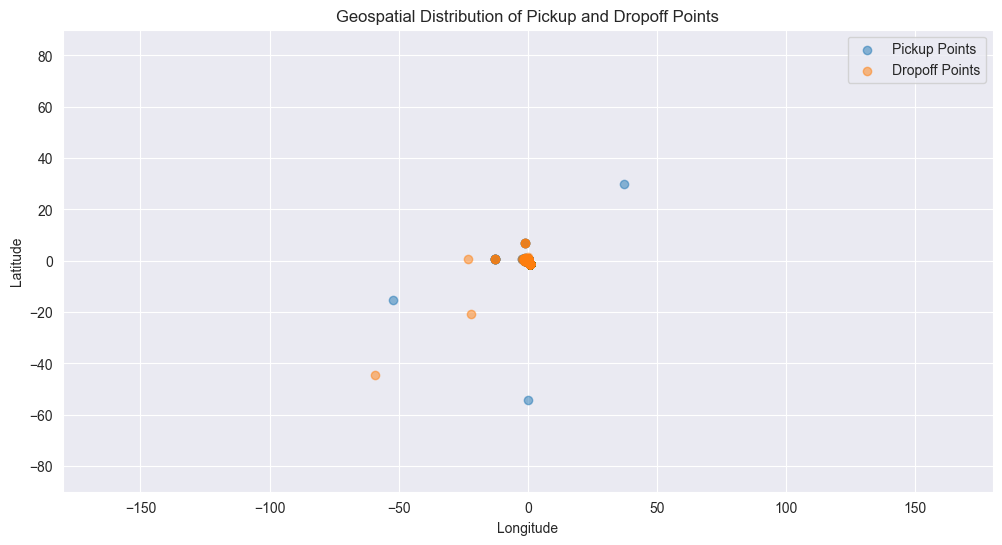

In [81]:

# Assuming df is your DataFrame containing the pickup and dropoff coordinates

# Step 1: Check for out-of-range values
invalid_pickup_longitude = df[(df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180)]
invalid_pickup_latitude = df[(df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90)]
invalid_dropoff_longitude = df[(df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)]
invalid_dropoff_latitude = df[(df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)]

# Step 2: Combine all invalid entries
invalid_coordinates = pd.concat([invalid_pickup_longitude, invalid_pickup_latitude, 
                                  invalid_dropoff_longitude, invalid_dropoff_latitude]).drop_duplicates()

# Step 3: Analyze invalid coordinates
print("Invalid Pickup Longitudes:\n", invalid_pickup_longitude)
print("Invalid Pickup Latitudes:\n", invalid_pickup_latitude)
print("Invalid Dropoff Longitudes:\n", invalid_dropoff_longitude)
print("Invalid Dropoff Latitudes:\n", invalid_dropoff_latitude)

# Step 4: Visualize using Matplotlib or Seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.5, label='Pickup Points')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], alpha=0.5, label='Dropoff Points')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.title('Geospatial Distribution of Pickup and Dropoff Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [22]:
# Generate descriptive statistics for numerical columns
print(df.describe())


         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  499981.000000     499981.000000    499981.000000      499981.000000   
mean       11.359033         -1.265716         0.696743          -1.265757   
std         9.915415          0.206929         0.140904           0.205898   
min         0.010000        -52.119764       -54.389440         -59.049665   
25%         6.000000         -1.291405         0.710958          -1.291393   
50%         8.500000         -1.291226         0.711268          -1.291197   
75%        12.500000         -1.290970         0.711520          -1.290908   
max       500.000000         37.360538        29.724576           0.712985   

       dropoff_latitude  passenger_count           hour            day  \
count     499981.000000    499981.000000  499981.000000  499981.000000   
mean           0.696676         1.687040      13.510821      15.684256   
std            0.128995         1.304153       6.511595       8.681131   
m

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499981 entries, 0 to 499985
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Car Condition      499981 non-null  object 
 1   Weather            499981 non-null  object 
 2   Traffic Condition  499981 non-null  object 
 3   fare_amount        499981 non-null  float64
 4   pickup_longitude   499981 non-null  float64
 5   pickup_latitude    499981 non-null  float64
 6   dropoff_longitude  499981 non-null  float64
 7   dropoff_latitude   499981 non-null  float64
 8   passenger_count    499981 non-null  int64  
 9   hour               499981 non-null  int64  
 10  day                499981 non-null  int64  
 11  month              499981 non-null  int64  
 12  weekday            499981 non-null  int64  
 13  year               499981 non-null  int64  
 14  jfk_dist           499981 non-null  float64
 15  ewr_dist           499981 non-null  float64
 16  lga_dis

In [82]:
df['Traffic Condition'].unique()

array(['Congested Traffic', 'Flow Traffic', 'Dense Traffic'], dtype=object)

In [108]:
column="Traffic Condition"
df[column] = df[column].replace("Congested Traffic", 0)
df[column] = df[column].replace("Dense Traffic", 1)
df[column] = df[column].replace("Flow Traffic", 2)

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/1311997710.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace("Flow Traffic", 2)


In [107]:
column="Weather"
df[column] = df[column].replace("sunny", 0)
df[column] = df[column].replace("cloudy", 1)
df[column] = df[column].replace("rainy", 2)
df[column] = df[column].replace("stormy", 3)
df[column] = df[column].replace("windy", 4)

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/1249278712.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace("windy", 4)


In [109]:
column="Car Condition"
df[column] = df[column].replace("Very Good", 0)
df[column] = df[column].replace("Bad", 1)
df[column] = df[column].replace("Good", 2)
df[column] = df[column].replace("Excellent", 3)

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/694207043.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace("Excellent", 3)


In [110]:
df.fare_amount.min()

0.01

In [111]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [112]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/1448170683.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df.loc[(df.weekday >= 0) & (df.weekday <=4)], palette='Set2')


<Axes: title={'center': 'Cab trips count during week days'}, xlabel='hour', ylabel='count'>

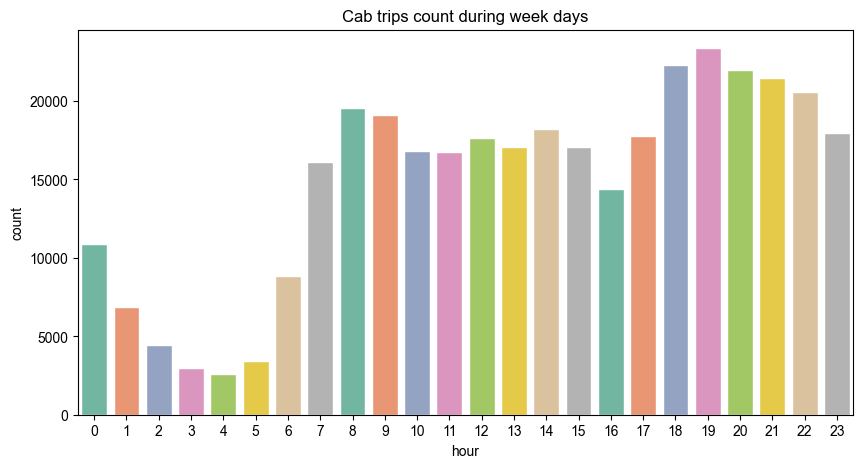

In [28]:

# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week days')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='hour', data=df.loc[(df.weekday >= 0) & (df.weekday <=4)], palette='Set2')

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/886179708.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df.loc[(df.weekday >= 5) & (df.weekday <=6)], palette='Set2')


<Axes: title={'center': 'Cab trips count during week ends'}, xlabel='hour', ylabel='count'>

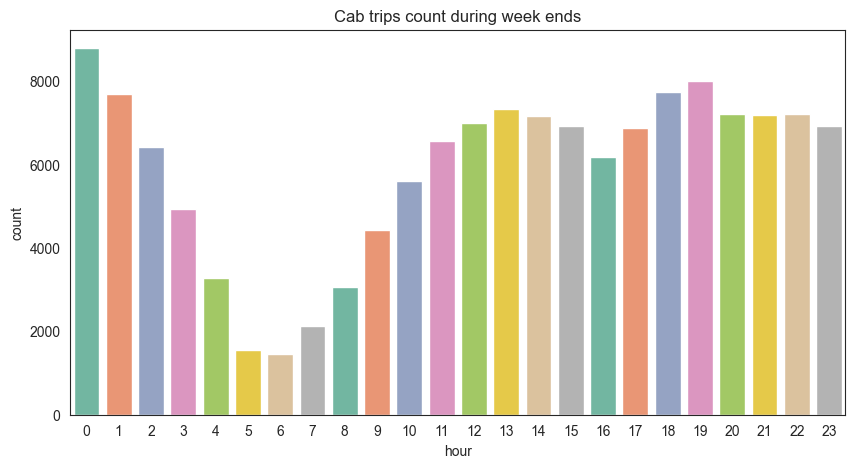

In [29]:

# Set the figure size, grid type and color palette along with appropraite title for the plot
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df.loc[(df.weekday >= 5) & (df.weekday <=6)], palette='Set2')

In [30]:
# Set the days in the dataset as week days and week ends
week_days = df.loc[(df.weekday >= 0) & (df.weekday <= 4)]
week_ends = df.loc[(df.weekday >= 5) & (df.weekday <= 6)]

# compute the mean fare amount over the week day and week end.
# use groupby('hour') to get the mean fare for each hour
week_days_fare = week_days.groupby(['hour']).fare_amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).fare_amount.mean().to_frame().reset_index()

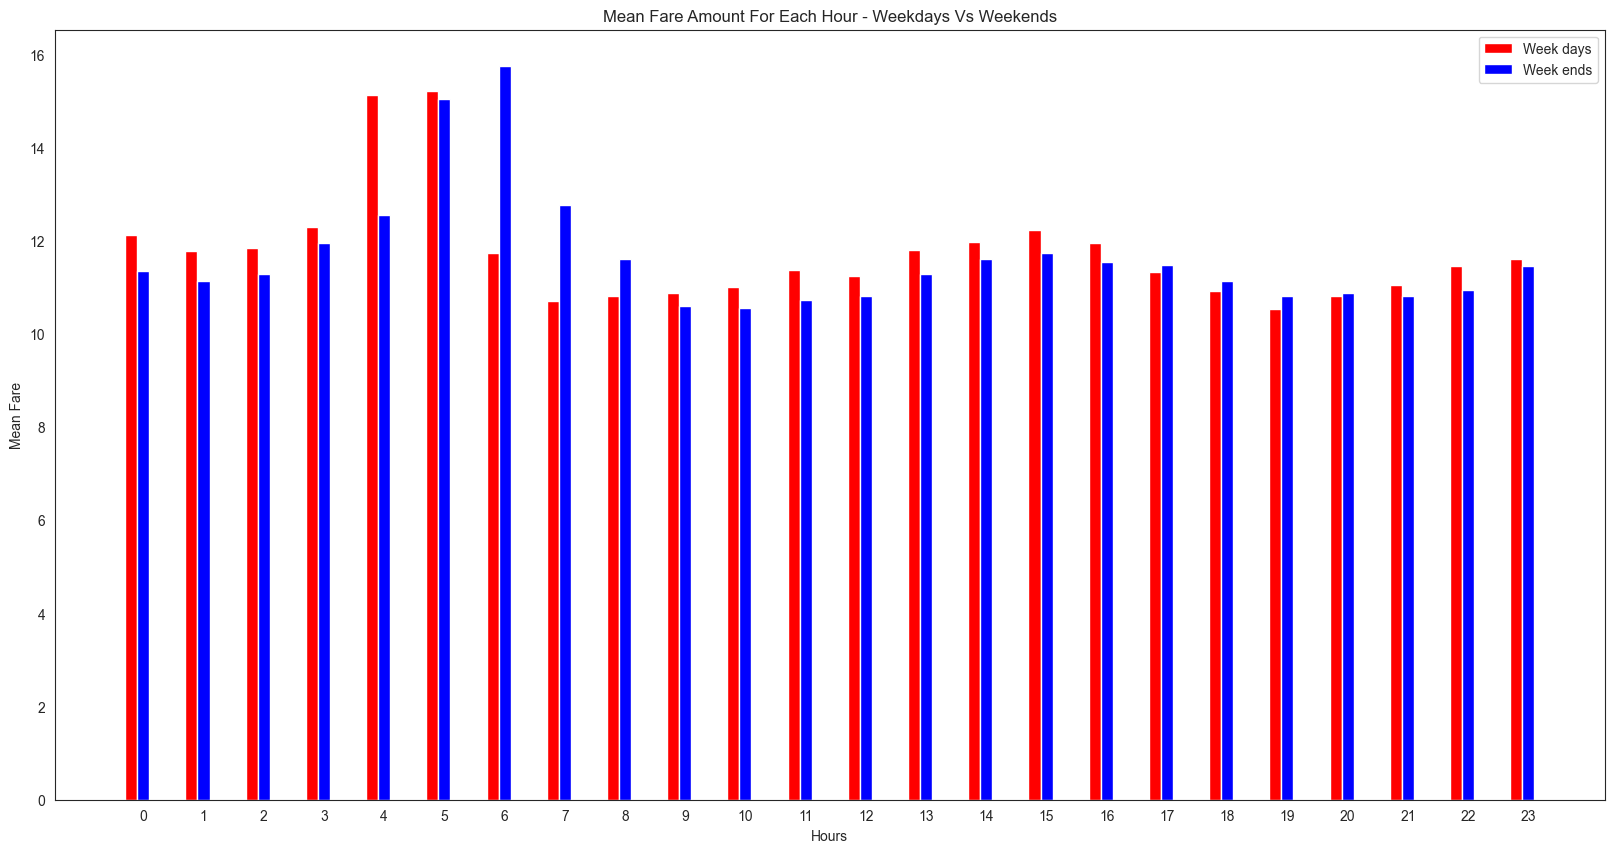

In [31]:

# hours
x = np.array(week_days_fare.hour)
# an array of week day fare 
y = np.array(week_days_fare.fare_amount)
# an array of week end fare
z = np.array(week_ends_fare.fare_amount)

# Set the figure size, title, x and y labels
plt.figure(figsize = (20,10))
plt.title('Mean Fare Amount For Each Hour - Weekdays Vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')
# Pass the three integers. The value of these integer should be less that 10
ax=plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center', label = 'Week days')
ax.bar(x, z, width=0.2, color='blue', align='center', label = 'Week ends')
plt.xticks(range(0,24))
plt.legend()
plt.show()

In [115]:

# Define the columns for which you want to drop outliers
columns_to_check = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance', 'bearing']

# Create a copy of the DataFrame (to avoid modifying the original data)
df_clean = df.copy()

# Calculate IQR and filter out outliers for each column
for column in columns_to_check:
    Q1 = df_clean[column].quantile(0.25)  # First quartile (25%)
    Q3 = df_clean[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the rows that are outliers
    df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

# Reset index after dropping outliers
df_clean.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
df_clean

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,1,3,0,5.7,-1.291242,0.711418,-1.291391,0.711231,2,0,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
1,0,3,2,7.7,-1.291319,0.710927,-1.291396,0.711363,1,4,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
2,1,3,0,5.3,-1.290987,0.711536,-1.290787,0.711811,1,7,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703
3,3,0,0,12.1,-1.291560,0.710901,-1.291071,0.711365,1,9,...,1,3,2011,42.335622,32.824930,20.648176,15.741133,7.649541,3.787239,-0.674251
4,3,4,2,7.5,-1.291195,0.711251,-1.291086,0.711481,1,20,...,11,1,2012,42.563234,35.482608,18.113693,19.126670,10.993150,1.555807,-0.342260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409842,0,4,0,13.0,-1.291337,0.711193,-1.291321,0.711028,5,22,...,1,5,2015,42.123722,32.557909,20.805410,15.446574,7.285943,1.055295,-3.067213
409843,1,2,1,7.0,-1.291173,0.711514,-1.290951,0.711371,1,18,...,5,3,2015,42.565403,36.580043,17.157511,20.401068,12.280187,1.404709,-2.275706
409844,0,2,2,13.7,-1.291595,0.710670,-1.291708,0.710540,1,12,...,9,0,2010,41.814877,27.833416,26.463167,8.596656,0.994796,0.994184,2.556931
409845,2,3,0,6.5,-1.291101,0.711335,-1.291023,0.711480,6,12,...,1,0,2015,42.292914,36.382813,17.227166,20.006433,11.819775,0.994470,-0.384817


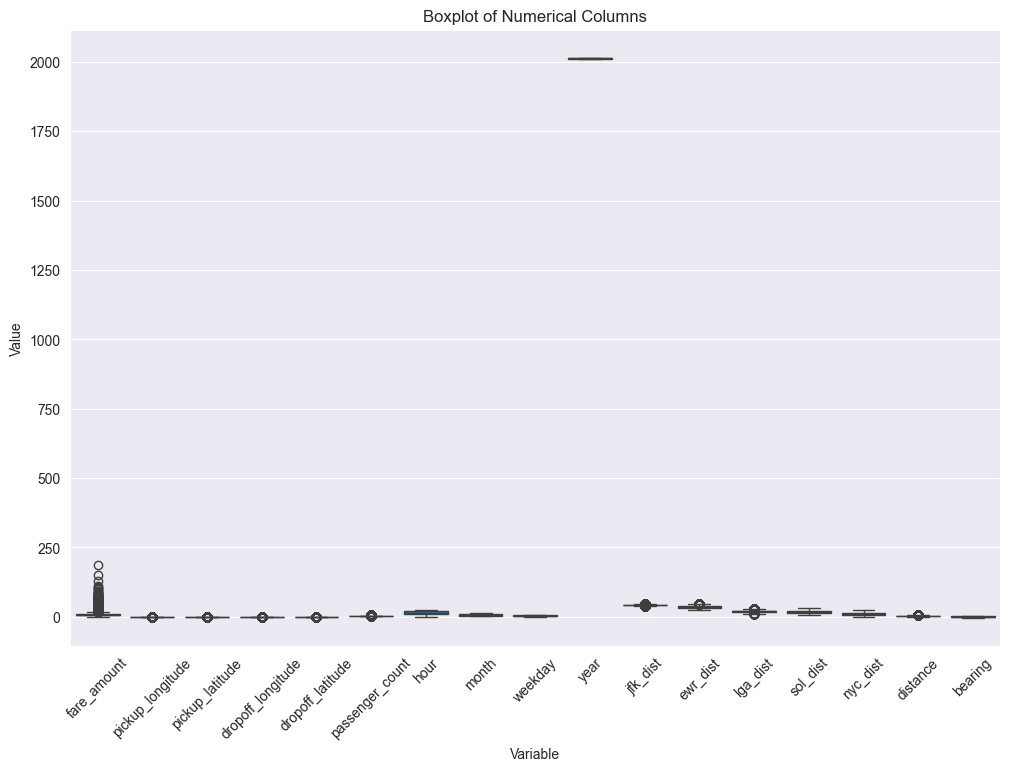

In [116]:

# Define numerical columns
numerical_columns = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 
                     'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 
                     'hour', 'month', 'weekday', 'year', 'jfk_dist', 
                     'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 
                     'distance', 'bearing']

# Ensure the DataFrame contains the specified numerical columns
missing_columns = [col for col in numerical_columns if col not in df_clean.columns]
if missing_columns:
    print("Missing columns:", missing_columns)

# Create boxplot for all numerical columns if they exist
if not missing_columns:
    # Melt the DataFrame to long format for seaborn
    df_melted = df_clean.melt(value_vars=numerical_columns, var_name='Variable', value_name='Value')

    # Create boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplot of Numerical Columns')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Cannot create boxplot because some numerical columns are missing.")


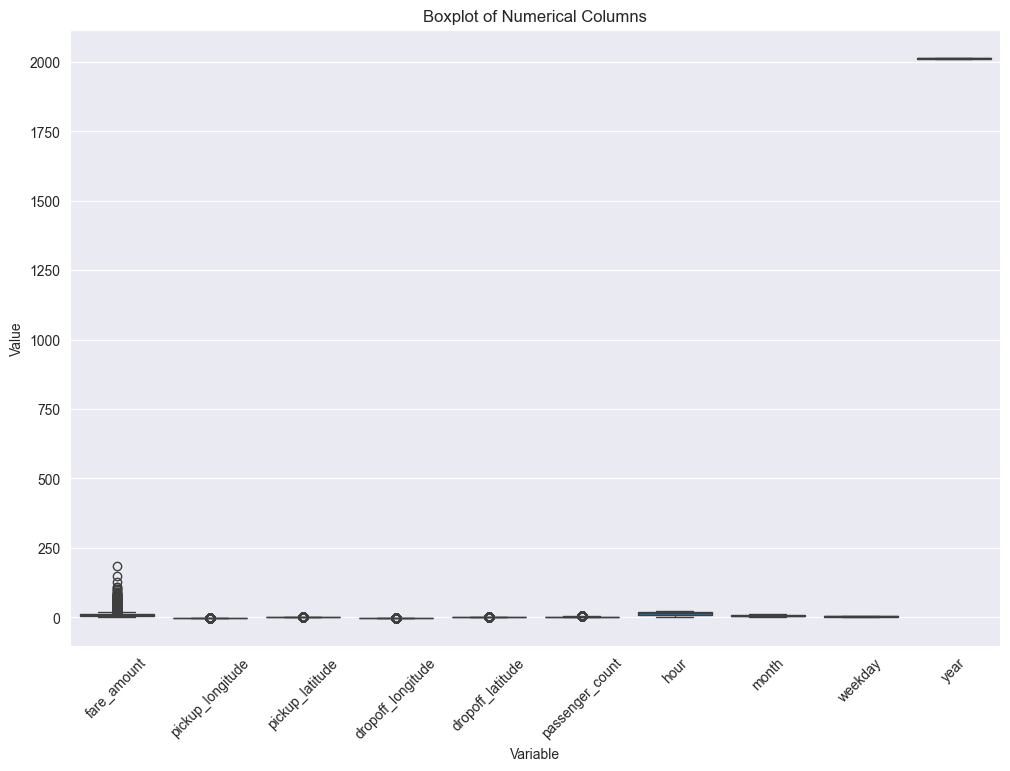

In [117]:




# Define numerical columns
numerical_columns = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 
                     'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 
                     'hour', 'month', 'weekday', 'year']

# Ensure the DataFrame contains the specified numerical columns
missing_columns = [col for col in numerical_columns if col not in df_clean.columns]
if missing_columns:
    print("Missing columns:", missing_columns)

# Create boxplot for all numerical columns if they exist
if not missing_columns:
    # Melt the DataFrame to long format for seaborn
    df_melted = df_clean.melt(value_vars=numerical_columns, var_name='Variable', value_name='Value')

    # Create boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplot of Numerical Columns')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Cannot create boxplot because some numerical columns are missing.")


/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/3353402524.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  snsplot = sns.kdeplot(df.fare_amount, shade=True)


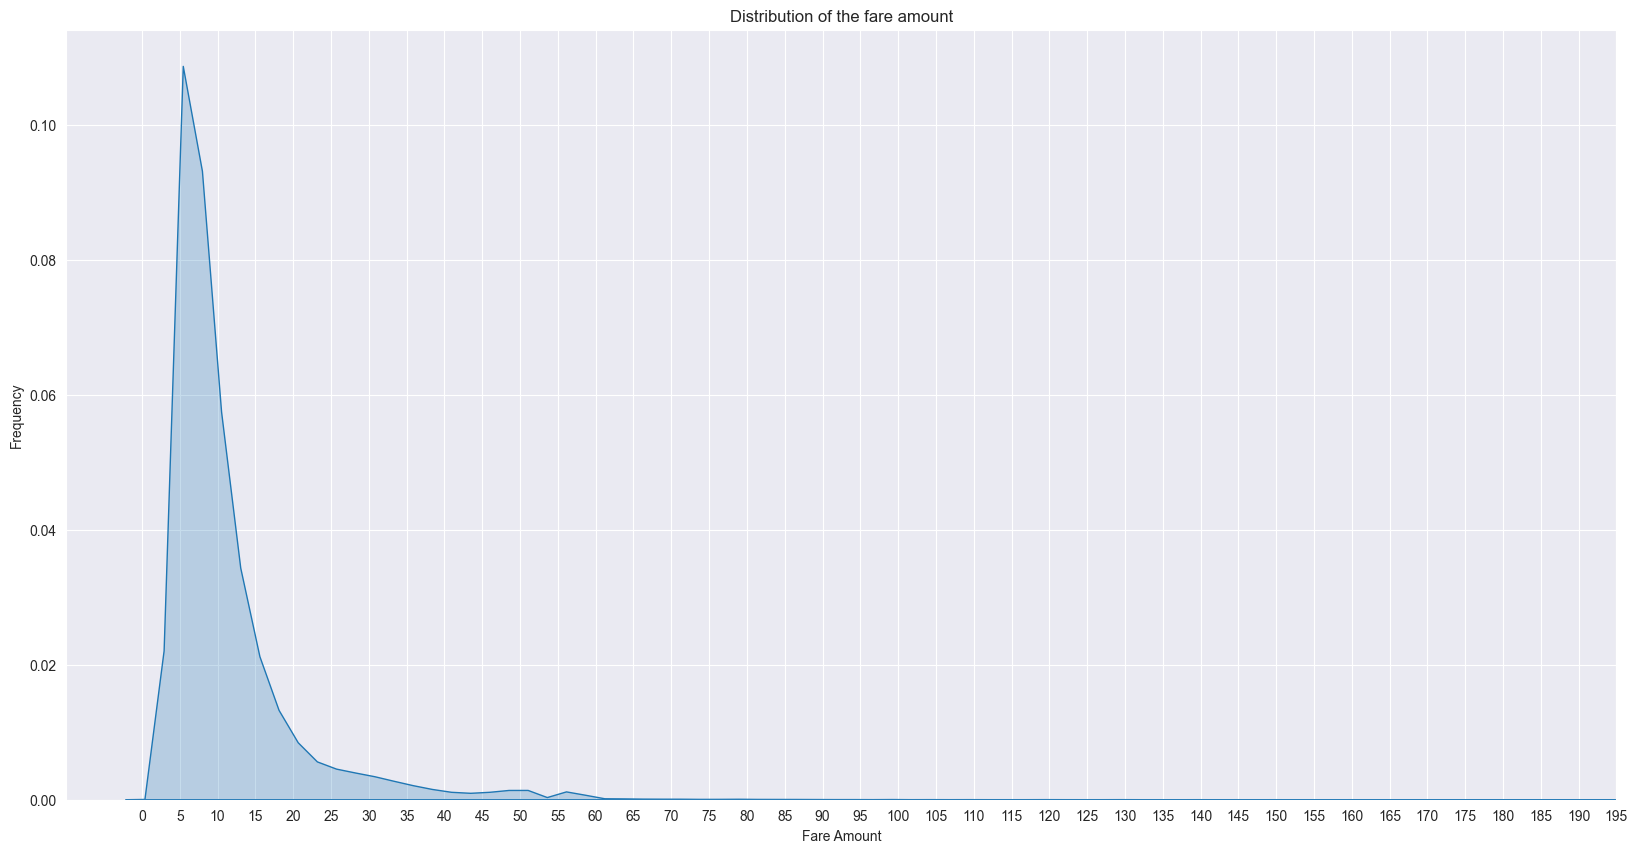

In [37]:

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df.fare_amount, shade=True)

/var/folders/_p/z0wlrjjj3n7d6kwjc9cm54sm0000gn/T/ipykernel_29666/2896829311.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.plot = sns.kdeplot(df[df.distance<600].distance, shade=True)


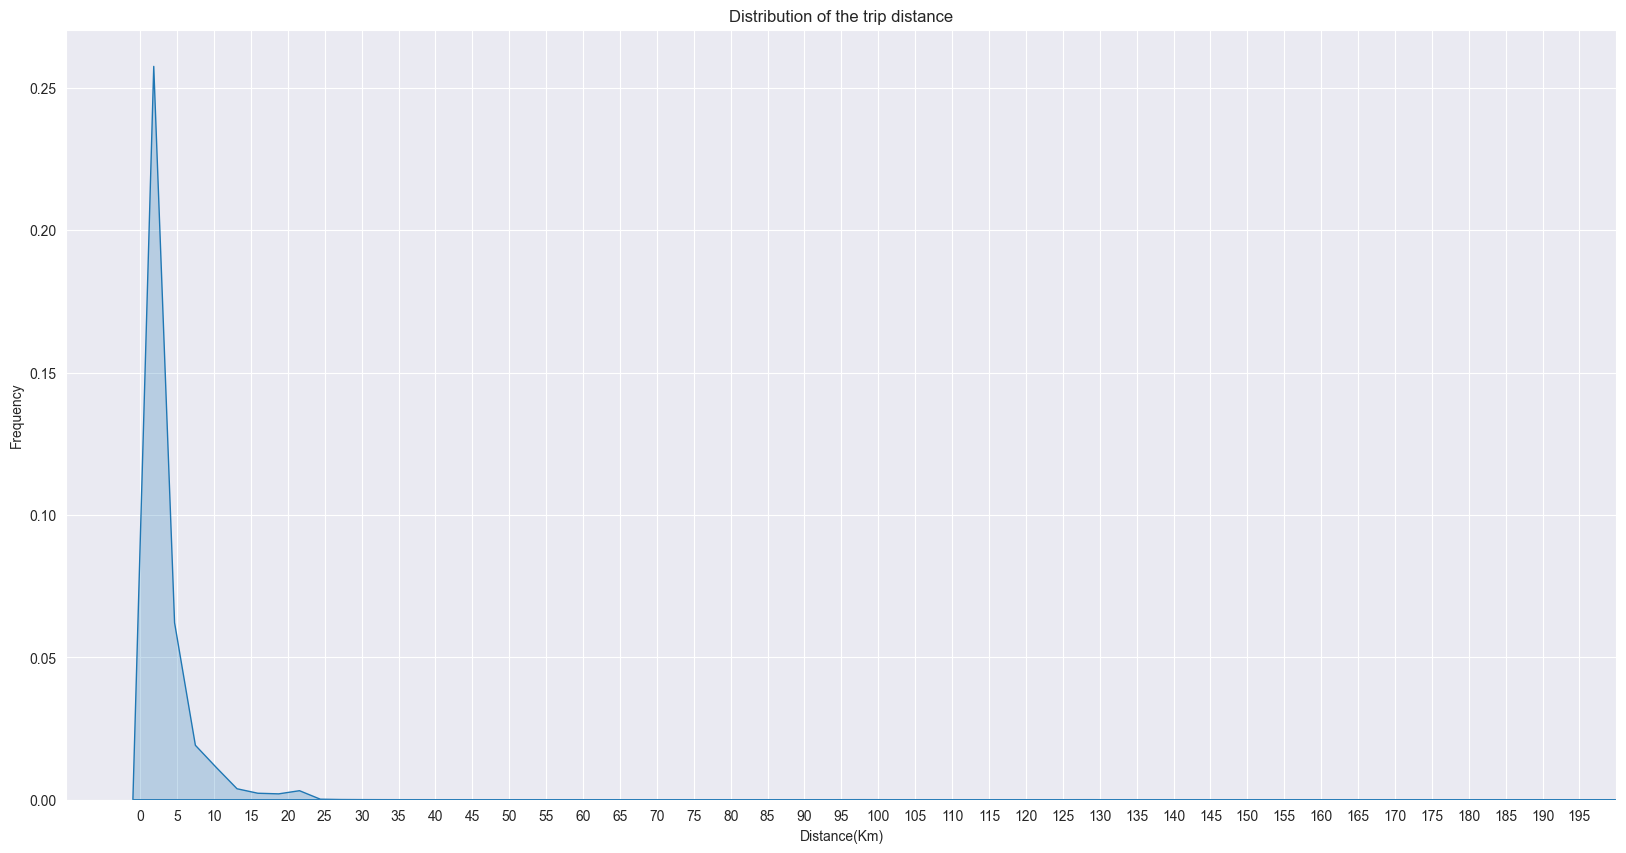

In [38]:
plt.figure(figsize = (20,10))
sns.style = ('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
plt.xlim(-10, 200)
plt.xticks(range(0,200,5))

sns.plot = sns.kdeplot(df[df.distance<600].distance, shade=True)

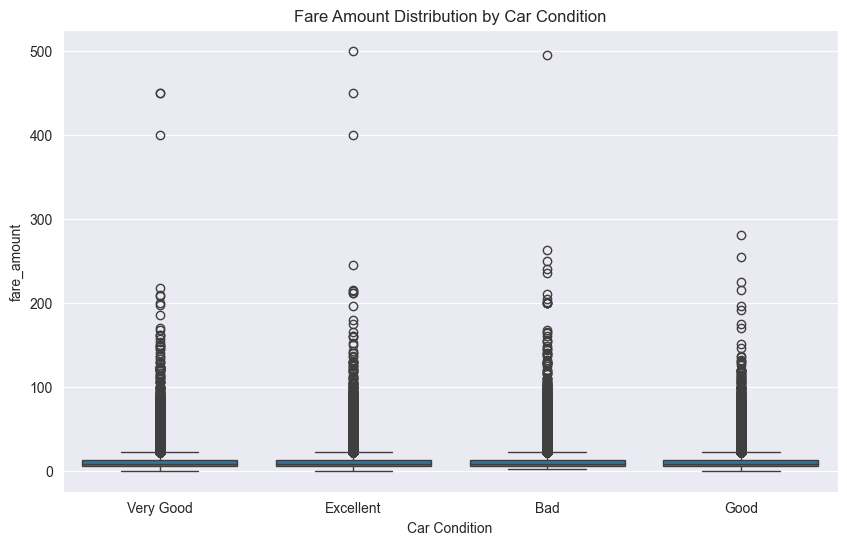

In [39]:


# Boxplot for 'Car Condition' vs fare_amount
plt.figure(figsize=(10,6))
sns.boxplot(x='Car Condition', y='fare_amount', data=df)
plt.title('Fare Amount Distribution by Car Condition')
plt.show()


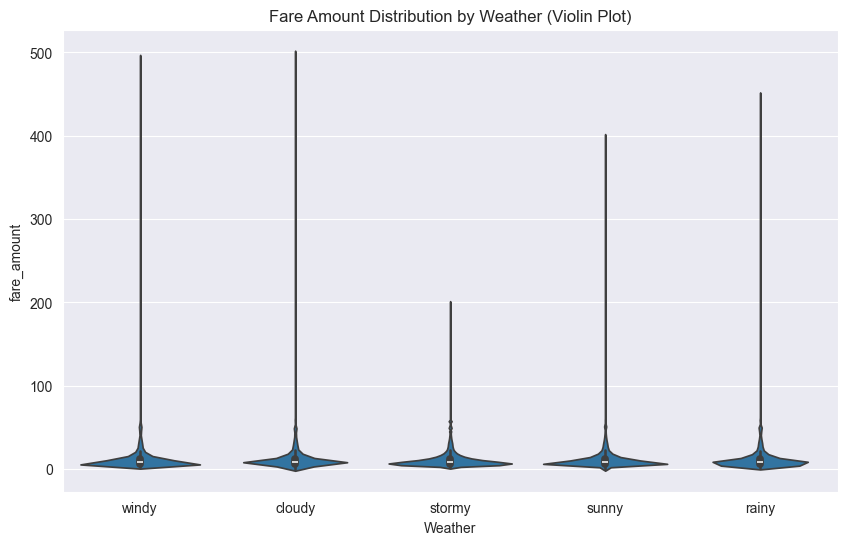

In [40]:
# Violin plot for 'Weather' vs fare_amount
plt.figure(figsize=(10,6))
sns.violinplot(x='Weather', y='fare_amount', data=df)
plt.title('Fare Amount Distribution by Weather (Violin Plot)')
plt.show()


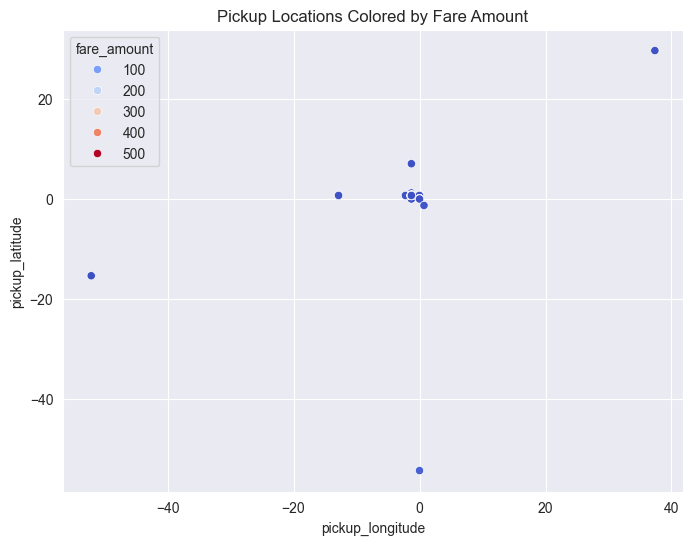

In [41]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, hue='fare_amount', palette='coolwarm')
plt.title('Pickup Locations Colored by Fare Amount')
plt.show()

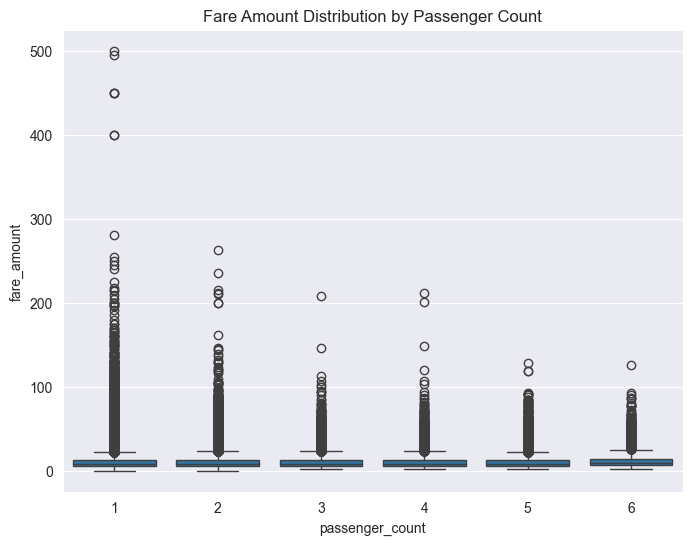

In [42]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount Distribution by Passenger Count')
plt.show()

In [157]:
# set up NewYou city coordinates
import folium
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

pickups = []
dropoffs = []
for index, row in data.iterrows():
    pickup = [math.degrees(row["pickup_latitude"]), math.degrees(row["pickup_longitude"])]
    dropoff = [math.degrees(row["dropoff_latitude"]), math.degrees(row["dropoff_longitude"])]
    pickups.append(pickup)
    dropoffs.append(dropoff)

# Plotting pickups and dropoffs
for index, (pickup, dropoff) in enumerate(zip(pickups[:100], dropoffs[:100])):
    folium.Marker(
        location=pickup,
        popup="Pickup",
        icon=folium.Icon(color="blue"),
    ).add_to(map_nyc)
    folium.Marker(
        location=dropoff,
        popup="Dropoff",
        icon=folium.Icon(color="red"),
    ).add_to(map_nyc)

map_nyc

In [113]:

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

In [118]:
features = [ "pickup_longitude", "pickup_latitude", "jfk_dist", "ewr_dist", "lga_dist", "sol_dist", "nyc_dist", "distance"]

In [119]:
for feature in features:
    df_clean[feature] = scaler.fit_transform(df_clean[[feature]])

In [120]:
df_clean.isna()

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409842,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
409843,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
409844,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
409845,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [121]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409847 entries, 0 to 409846
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Car Condition      409847 non-null  int64  
 1   Weather            409847 non-null  int64  
 2   Traffic Condition  409847 non-null  int64  
 3   fare_amount        409847 non-null  float64
 4   pickup_longitude   409847 non-null  float64
 5   pickup_latitude    409847 non-null  float64
 6   dropoff_longitude  409847 non-null  float64
 7   dropoff_latitude   409847 non-null  float64
 8   passenger_count    409847 non-null  int64  
 9   hour               409847 non-null  int64  
 10  day                409847 non-null  int64  
 11  month              409847 non-null  int64  
 12  weekday            409847 non-null  int64  
 13  year               409847 non-null  int64  
 14  jfk_dist           409847 non-null  float64
 15  ewr_dist           409847 non-null  float64
 16  lg

In [122]:


# Separate the features (X) and the target variable (y)
X = df_clean.drop(columns=["fare_amount"])
y = df_clean["fare_amount"]

# Split the dataset (80% train, 20% test is typical)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (327877, 20)
Shape of y_train (327877,)
Shape of X_test (81970, 20)
Shape of y_test (81970,)


In [126]:


# Initialize LinearRegression
estimator = LinearRegression()

# Loop through the number of features to select the top i features
for i in range(1, 19):
    selector = RFE(estimator, n_features_to_select=i)
    selector = selector.fit(X, y)
    
    selected_features = X.columns[selector.support_]
    print(f"Selected best {i} Features: {list(selected_features)}")


Selected best 1 Features: ['dropoff_latitude']
Selected best 2 Features: ['dropoff_longitude', 'dropoff_latitude']
Selected best 3 Features: ['dropoff_longitude', 'dropoff_latitude', 'distance']
Selected best 4 Features: ['dropoff_longitude', 'dropoff_latitude', 'nyc_dist', 'distance']
Selected best 5 Features: ['dropoff_longitude', 'dropoff_latitude', 'ewr_dist', 'nyc_dist', 'distance']
Selected best 6 Features: ['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'ewr_dist', 'nyc_dist', 'distance']
Selected best 7 Features: ['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'ewr_dist', 'sol_dist', 'nyc_dist', 'distance']
Selected best 8 Features: ['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance']
Selected best 9 Features: ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance']
Selected best 10 Features: ['picku

In [53]:
# Selecting the top 10 features
best_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance']

# Create new datasets with only the selected features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]



In [55]:


# Initialize the model (RandomForestRegressor in this case)
model = RandomForestRegressor(random_state=42)

# Fit the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')


MAE: 1.6814570409975533
MSE: 9.387732523606799
R²: 0.5328579330472878


In [56]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model.__class__.__name__} Performance:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")
    print("-" * 40)


In [59]:

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
evaluate_model(gbr, X_train_selected, X_test_selected, y_train, y_test)


GradientBoostingRegressor Performance:
MAE: 1.7373450779051625
MSE: 9.503632496871049
R²: 0.5270906454797865
----------------------------------------


In [ ]:
#Deep learning model
model = Sequential(
    [
        Dense(30, activation="relu"),
        Dense(15, activation="relu"),
        Dense(1, activation="linear"),
    ]
)

In [127]:
from keras.optimizers import Adam


model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

In [128]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 328.6752
Epoch 2/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 13.2964
Epoch 3/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 12.9301
Epoch 4/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 12.4242
Epoch 5/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 11.3765
Epoch 6/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 11.3409
Epoch 7/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 11.6417
Epoch 8/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 11.1767
Epoch 9/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 11.0801
Epoch 10/10
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 11.1027


In [105]:
df_clean

,Car Condition,Weather,Traffic Condition,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,Bad,stormy,Congested Traffic,5.7,-0.047737,0.414016,-1.291391,0.711231,2,0,...,8,3,2011,0.528328,-0.217901,0.096123,-0.025920,-0.014513,-0.611854,2.599961
1,Very Good,stormy,Flow Traffic,7.7,-0.322168,-0.951880,-1.291396,0.711363,1,4,...,4,5,2012,-0.061145,-0.549648,0.475316,-0.477660,-0.519298,0.365823,0.133905
2,Bad,stormy,Congested Traffic,5.3,0.867218,0.741225,-1.290787,0.711811,1,7,...,3,1,2010,0.363021,1.416663,-1.374612,1.342692,1.340121,-0.189067,-0.502703
3,Excellent,sunny,Congested Traffic,12.1,-1.186574,-1.025354,-1.291071,0.711365,1,9,...,1,3,2011,-0.250908,-0.472540,0.343956,-0.477166,-0.531984,1.050992,-0.674251
4,Excellent,windy,Flow Traffic,7.5,0.123219,-0.052565,-1.291086,0.711481,1,20,...,11,1,2012,-0.110373,0.290293,-0.458367,0.293825,0.255266,-0.496536,-0.342260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409842,Very Good,windy,Congested Traffic,13.0,-0.387429,-0.213487,-1.291321,0.711028,5,22,...,1,5,2015,-0.381742,-0.549183,0.393730,-0.544246,-0.617593,-0.843647,-3.067213
409843,Bad,rainy,Dense Traffic,7.0,0.199886,0.678854,-1.290951,0.711371,1,18,...,5,3,2015,-0.109034,0.605290,-0.761059,0.584044,0.558298,-0.601324,-2.275706
409844,Very Good,rainy,Flow Traffic,13.7,-1.309543,-1.667437,-1.291708,0.710540,1,12,...,9,0,2010,-0.572431,-1.905255,2.184766,-2.104183,-2.098838,-0.886029,2.556931
409845,Good,stormy,Congested Traffic,6.5,0.459696,0.182944,-1.291023,0.711480,6,12,...,1,0,2015,-0.277277,0.548679,-0.739009,0.494174,0.449894,-0.885830,-0.384817


In [129]:
loss = model.evaluate(X_train, y_train)

10247/10247 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 10.6655


In [130]:
loss = model.evaluate(X_test, y_test)

2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 10.6632


In [58]:
from joblib import dump

In [132]:
#saving the model
model.save('my_model.keras')


In [108]:
"""
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}
"""

In [109]:
"""
#choosing XGBRegressor for hypertuning
# Initialize XGBRegressor
xgb = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                                       n_iter=10, scoring='neg_mean_absolute_error', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
xgb_random_search.fit(X_train_selected, y_train)

# Print best parameters
print(f"Best Parameters for XGBRegressor: {xgb_random_search.best_params_}")
"""


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBRegressor: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [110]:
"""
# Get the best estimator
best_xgb = xgb_random_search.best_estimator_

# Evaluate the model using your custom function
evaluate_model(best_xgb, X_train_scaled, X_test_scaled, y_train, y_test)
"""


XGBRegressor Performance:
MAE: 2.1680611117798807
MSE: 21.89600809638598
R²: 0.7766838337403599
----------------------------------------


In [113]:
"""

# Calculate R² score for the training data
y_train_pred = xgb_random_search.predict(X_train_selected)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate R² score for the test data
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Set R² Score: {train_r2}")
print(f"Test Set R² Score: {test_r2}")

"""

Training Set R² Score: 0.8522180613242017
Test Set R² Score: 0.7766838337403599
